# QMC 관련 필기

(2024-10-16)

- numpy pseudo random 만들고 
- qmc랑 비교. 
    - Sobol, 걍 scipy로 부르면 쉽게 쓸 수 있다. 

## pseudo_vs_quasi.py

Text(0.5, 1.0, 'Quasi-random')

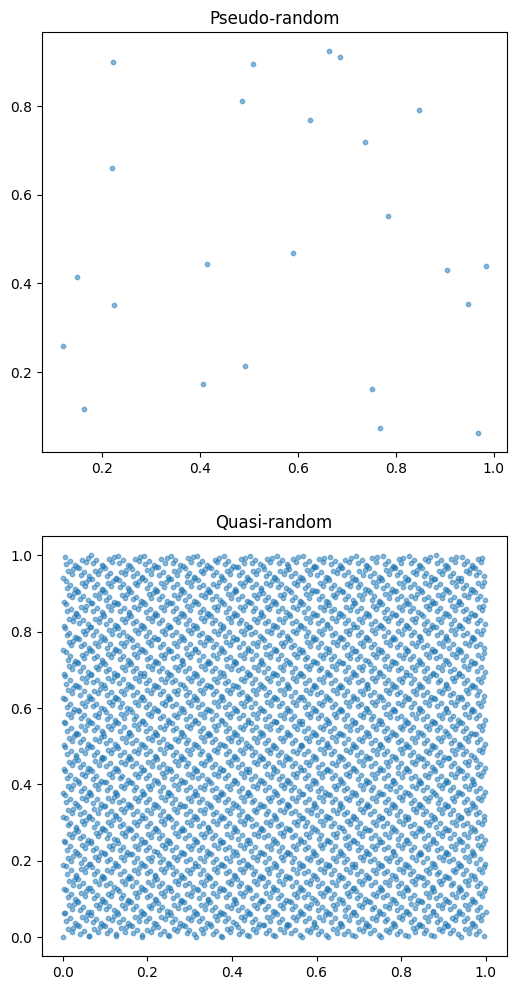

In [3]:
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

n = 12
pseudo = np.random.random( (2*n, 2) )
dist = qmc.Sobol(2, scramble=False) # True가 default 
quasi = dist.random_base2(n) # 2의 n승으로 뽑는다. 

fig, ax = plt.subplots(2, 1, figsize=(6, 12))
ax[0].scatter(pseudo[:, 0], pseudo[:, 1], s=10, alpha=0.5)
ax[0].set_title('Pseudo-random')

ax[1].scatter(quasi[:, 0], quasi[:, 1], s=10, alpha=0.5)
ax[1].set_title('Quasi-random')

딱봐도 quasi-random은 뭔가 패턴이 있다. 

## qmc.py

In [4]:
qmc.MultivariateNormalQMC # qmc price 구할 때

scipy.stats._qmc.MultivariateNormalQMC

와... 그래프 보여주신거 보니까 QMC가 쎄긴 쎄네. 

2^18 쯤 해야 MC가 converge하는걸 QMC는 순식간에 수렴해버린다. 한 1000개? 도 안되는 곳에서 수렴을 끝내버림. 개쩔긴 하네.... 

** 참고 교수님 파이썬 환경 3.12 base conda

QMC의 의의를 다시 생각해보자. 

해석적인 해? 좋지 있으면... 근데 저차원에서나 closed form이 있지. 그리고 계산하는 난이도? 차원이 올라가면 기하급수적으로 증가해. 

QMC는 차원 늘어도 선형적으로 증가. 이게 개쩌는 부분. 

위에서 보여주신거만 해도 impressive한데 이건 아무것도 아니라고 함. 저런 1차원에서 숫자 줄이려고 QMC쓰는거 아니라고... ㄷㄷ

코드에 설명 더 적어놓음. 

## 시뮬레이션 그 이후. 추가 내용

- 원래 reference로 쓴 책, variance reduction technique 내용 엄청 많다. 그 책 두껍고 모든 내용 못다뤘다. 
- 못 다룬 내용 중 꼭 알았으면 하는 내용이 2개 있다. 


### 1. 민감도를 계산하는 방법. 
- 여태의 실습은 다 가격을 구하는 방법, 오차를 줄이는 방법 이런걸 했는데, 실제로 운용하는 입장에선 가격은 처음 거래할 때 중요하지만 이후 운용할 때는 그리 중요하지 않을수 있다. 
- 어떤 포지션 잡아야할지는 가격은 상관없고 민감도를 헤지하는 것이 더 중요할 수 있음. 
- MC로 민감도는 어떻게 구하는가? 
    - 5 가지 greeks
        - 기초자산에 대한 민감도 delta, gamma
        - 변동성에 대한 민감도 vega
        - 금리에 대한 민감도 rho
        - 시간에 대한 민감도 theta 
- f(theta)라는 뭔가가 있다고 치자. 저 theta는 greeks 아님. 
- f(theta + delta) - f(theta) / delta 해서 기울기 구할텐데, 
    - 오차가 커진다. f가 두개나 되자너... 
    - 오차를 줄이는 가장 쉬운 방법은? f(theta)의 오차와 f(theta + delta)의 오차 상관관계가 높게 만들면 - 하면서 빠진다. 
    - simulation할 때의 random number를 같은걸 써주면 바로 쉽게 해결 ㅎㅎ 
        - 두 개의 random number를 공통으로 사용하는게 기본 of 기본! 무조건 ㅇㅇ 
        - seed number를 고정해서 같게 주는 것이 중요. 
            - pseudo random이 그냥 random보다 나은 경우가 있다고 했던거 기억나나? 바로 이럴 때다. 둘 모두 같은 seed를 줘야하는데 pure random이면 답이 없음 ㅇㅇ 
- 그 외에도
    - f(x) = E( h(x) * p(x) )
    - path-wise 방법: 확률밀도함수 h를 미분
    - likelihood 방법: payoff p를 미분

### 2. American Option의 평가
- 실무에서 굉장히 중요. 
    - ELS 평가할 때, 이건 American은 아니지만 American처럼 평가를 한다. 
    - 그 이유는, 수치해석에서 digital option overhedge 한다고 했지? 이 overhedge 부분에서 평가를 할 때 American처럼 해야하는 경우가 생김. 
- 근데 American, MC에서 구현하기 상당히 까다로움 ㅠㅠ 
    - American put이면 아래 어딘가에서 중도상환이 유리할 수 있어지는데 
    - backwardation 뒤에서 앞으로 오니까 행사 value랑 현재가치랑 비교하면 비교 가능하니까 쉽다. 
    - MC는 앞에서 뒤로 가는거라 그게 안됨 ㅠㅠ 
        - exercise boundary를 사전적으로 정해주지 않는 이상 풀기 어려워진다. 
        - 이 난제를 어떻게 푸냐가 American Option 평가의 핵심. 
- 결국, 일단 terminal까지해서 payoff를 구하고 
    - 중간시점의 기대값을 구하고 뭐 이러면서 결국 backwardation 써야한다는듯? 

    